In [226]:
import pandas as pd 
import matplotlib.pyplot as plt  
import pytorch_lightning as pl
import torch.nn as nn
import torch
from pytorch_forecasting import  TemporalFusionTransformer
import torch 
from torch.utils.data import DataLoader
import seaborn as sns
from pytorch_forecasting.data.timeseries import TimeSeriesDataSet
from pytorch_forecasting.metrics import MultiHorizonMetric, MAE
from pytorch_lightning import Trainer


In [250]:
# Dataset HyperParam
num_feat_to_include = 20  # Set the number of features to include range(0,51)
ratio_of_data_splitting = 0.7 # Increasing the ratio is increasing the train_split

# DataLoader
num_workers=7

# Model HyperParam
reduce_lr_on_num_of_epochs = 20 # Every 20 epoch the lr is reduced by a factor of 10
lr = 0.001
hidden_size = 32
attention_head_size = 8
DropOut=0.3
hidden_continuous_size=16
max_encoder_length = 100  # Number of past time steps to consider
max_prediction_length = 200 # Number of future time steps to predict
batch_size =  8 # Adjust based on your system capacity


# Reading CSVs

In [251]:
gold_prices_target = pd.read_csv('../InputData/target_gold.csv')
gold_prices_target.columns = gold_prices_target.columns.str.lower()
gold_prices_target['date'] = pd.to_datetime(gold_prices_target['date'], format='mixed', utc=True).dt.date
gold_prices_target['date'] = pd.to_datetime(gold_prices_target['date'], utc=True)
gold_prices_target

,date,pct_change
0,2020-01-01 00:00:00+00:00,0.129032
1,2020-01-02 00:00:00+00:00,1.288660
2,2020-01-03 00:00:00+00:00,0.636132
3,2020-01-04 00:00:00+00:00,0.126422
4,2020-01-05 00:00:00+00:00,1.262626
...,...,...
1456,2023-12-27 00:00:00+00:00,-4.334869
1457,2023-12-28 00:00:00+00:00,1.302747
1458,2023-12-29 00:00:00+00:00,1.593514
1459,2023-12-30 00:00:00+00:00,0.000000


# Merging all features into one DataFrame


In [252]:
merged = pd.read_csv('../data/merged.csv')
merged['date'] = pd.to_datetime(merged['date'], format='mixed', utc=True).dt.date
merged['date'] = pd.to_datetime(merged['date'], utc=True)
print(merged.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1454 entries, 0 to 1453
Data columns (total 55 columns):
 #   Column                                               Non-Null Count  Dtype              
---  ------                                               --------------  -----              
 0   Unnamed: 0                                           1454 non-null   int64              
 1   date                                                 1454 non-null   datetime64[ns, UTC]
 2   closing_price                                        1454 non-null   float64            
 3   lag1                                                 1454 non-null   float64            
 4   lag2                                                 1454 non-null   float64            
 5   wti oil price fob (dollars per barrel)               1454 non-null   float64            
 6   europe brent crude oil (dollars per barrel)          1454 non-null   float64            
 7   effr                                      

In [253]:
merged

,Unnamed: 0,date,closing_price,lag1,lag2,wti oil price fob (dollars per barrel),europe brent crude oil (dollars per barrel),effr,overnight deposit rate,overnight lending rate,...,stock_8_real_estate_volume,stock_9_non-banking_financial_services_volume,open,high,low,close,open_vxeem_index,high_vxeem_index,low_vxeem_index,close_vxeem_index
0,0,2020-01-05 00:00:00+00:00,792.0,791.0,786.0,63.00,69.08,1.55,9.25,10.25,...,1.250162e+06,1.222827e+06,15.01,16.20,13.13,14.02,17.70,18.36,16.83,18.31
1,1,2020-01-06 00:00:00+00:00,802.0,792.0,791.0,63.27,70.25,1.55,9.25,10.25,...,1.746028e+06,7.705640e+05,15.45,16.39,13.54,13.85,18.95,19.24,17.35,17.63
2,2,2020-01-07 00:00:00+00:00,802.0,802.0,792.0,62.70,68.74,1.55,9.25,10.25,...,3.936622e+06,5.734652e+05,13.84,14.46,13.39,13.79,17.48,17.94,15.84,16.10
3,3,2020-01-08 00:00:00+00:00,808.0,802.0,802.0,59.65,67.31,1.55,9.25,10.25,...,4.958450e+06,4.689240e+05,15.16,15.24,12.83,13.45,16.44,20.68,15.21,16.21
4,4,2020-01-09 00:00:00+00:00,785.0,808.0,802.0,59.56,66.58,1.55,9.25,10.25,...,2.674743e+06,3.039950e+05,12.95,13.24,12.53,12.54,15.88,16.06,14.96,15.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1449,1449,2023-12-24 00:00:00+00:00,3525.0,3486.0,3486.0,73.29,80.23,5.33,19.25,20.25,...,2.877175e+06,3.156131e+06,13.72,13.96,13.00,13.03,20.14,20.14,17.30,17.31
1450,1450,2023-12-25 00:00:00+00:00,3662.0,3525.0,3486.0,73.29,80.23,5.33,19.25,20.25,...,1.881975e+06,2.997081e+06,13.72,13.96,13.00,13.03,20.14,20.14,17.30,17.31
1451,1451,2023-12-26 00:00:00+00:00,3806.0,3662.0,3525.0,75.84,80.23,5.33,19.25,20.25,...,1.332753e+06,2.541857e+06,13.77,13.80,12.96,12.99,21.63,21.63,17.22,17.34
1452,1452,2023-12-27 00:00:00+00:00,3691.0,3806.0,3662.0,74.31,80.97,5.33,19.25,20.25,...,6.763224e+06,2.648968e+06,13.02,13.04,12.37,12.43,21.43,21.43,17.13,17.29


In [254]:
print(gold_prices_target.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   date        1461 non-null   datetime64[ns, UTC]
 1   pct_change  1461 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(1)
memory usage: 23.0 KB
None


In [255]:
# final dataset with target variable(gold_prices_target)
merged = merged.merge(gold_prices_target, on='date', how='left')
merged['date'] = pd.to_datetime(merged['date']).dt.date
merged.sort_values(by='date', ascending=True, inplace=True)
merged.reset_index(drop=True, inplace=True)
print(merged.info())
merged.date.dtype

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1454 entries, 0 to 1453
Data columns (total 56 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   Unnamed: 0                                           1454 non-null   int64  
 1   date                                                 1454 non-null   object 
 2   closing_price                                        1454 non-null   float64
 3   lag1                                                 1454 non-null   float64
 4   lag2                                                 1454 non-null   float64
 5   wti oil price fob (dollars per barrel)               1454 non-null   float64
 6   europe brent crude oil (dollars per barrel)          1454 non-null   float64
 7   effr                                                 1454 non-null   float64
 8   overnight deposit rate                               1454 non-null  

dtype('O')

In [256]:
merged.head()

,Unnamed: 0,date,closing_price,lag1,lag2,wti oil price fob (dollars per barrel),europe brent crude oil (dollars per barrel),effr,overnight deposit rate,overnight lending rate,...,stock_9_non-banking_financial_services_volume,open,high,low,close,open_vxeem_index,high_vxeem_index,low_vxeem_index,close_vxeem_index,pct_change
0,0,2020-01-05,792.0,791.0,786.0,63.00,69.08,1.55,9.25,10.25,...,1.222827e+06,15.01,16.20,13.13,14.02,17.70,18.36,16.83,18.31,1.262626
1,1,2020-01-06,802.0,792.0,791.0,63.27,70.25,1.55,9.25,10.25,...,7.705640e+05,15.45,16.39,13.54,13.85,18.95,19.24,17.35,17.63,0.000000
2,2,2020-01-07,802.0,802.0,792.0,62.70,68.74,1.55,9.25,10.25,...,5.734652e+05,13.84,14.46,13.39,13.79,17.48,17.94,15.84,16.10,0.748130
3,3,2020-01-08,808.0,802.0,802.0,59.65,67.31,1.55,9.25,10.25,...,4.689240e+05,15.16,15.24,12.83,13.45,16.44,20.68,15.21,16.21,-2.846535
4,4,2020-01-09,785.0,808.0,802.0,59.56,66.58,1.55,9.25,10.25,...,3.039950e+05,12.95,13.24,12.53,12.54,15.88,16.06,14.96,15.35,0.254777


## Visualization

# Visualizing features using heatmap

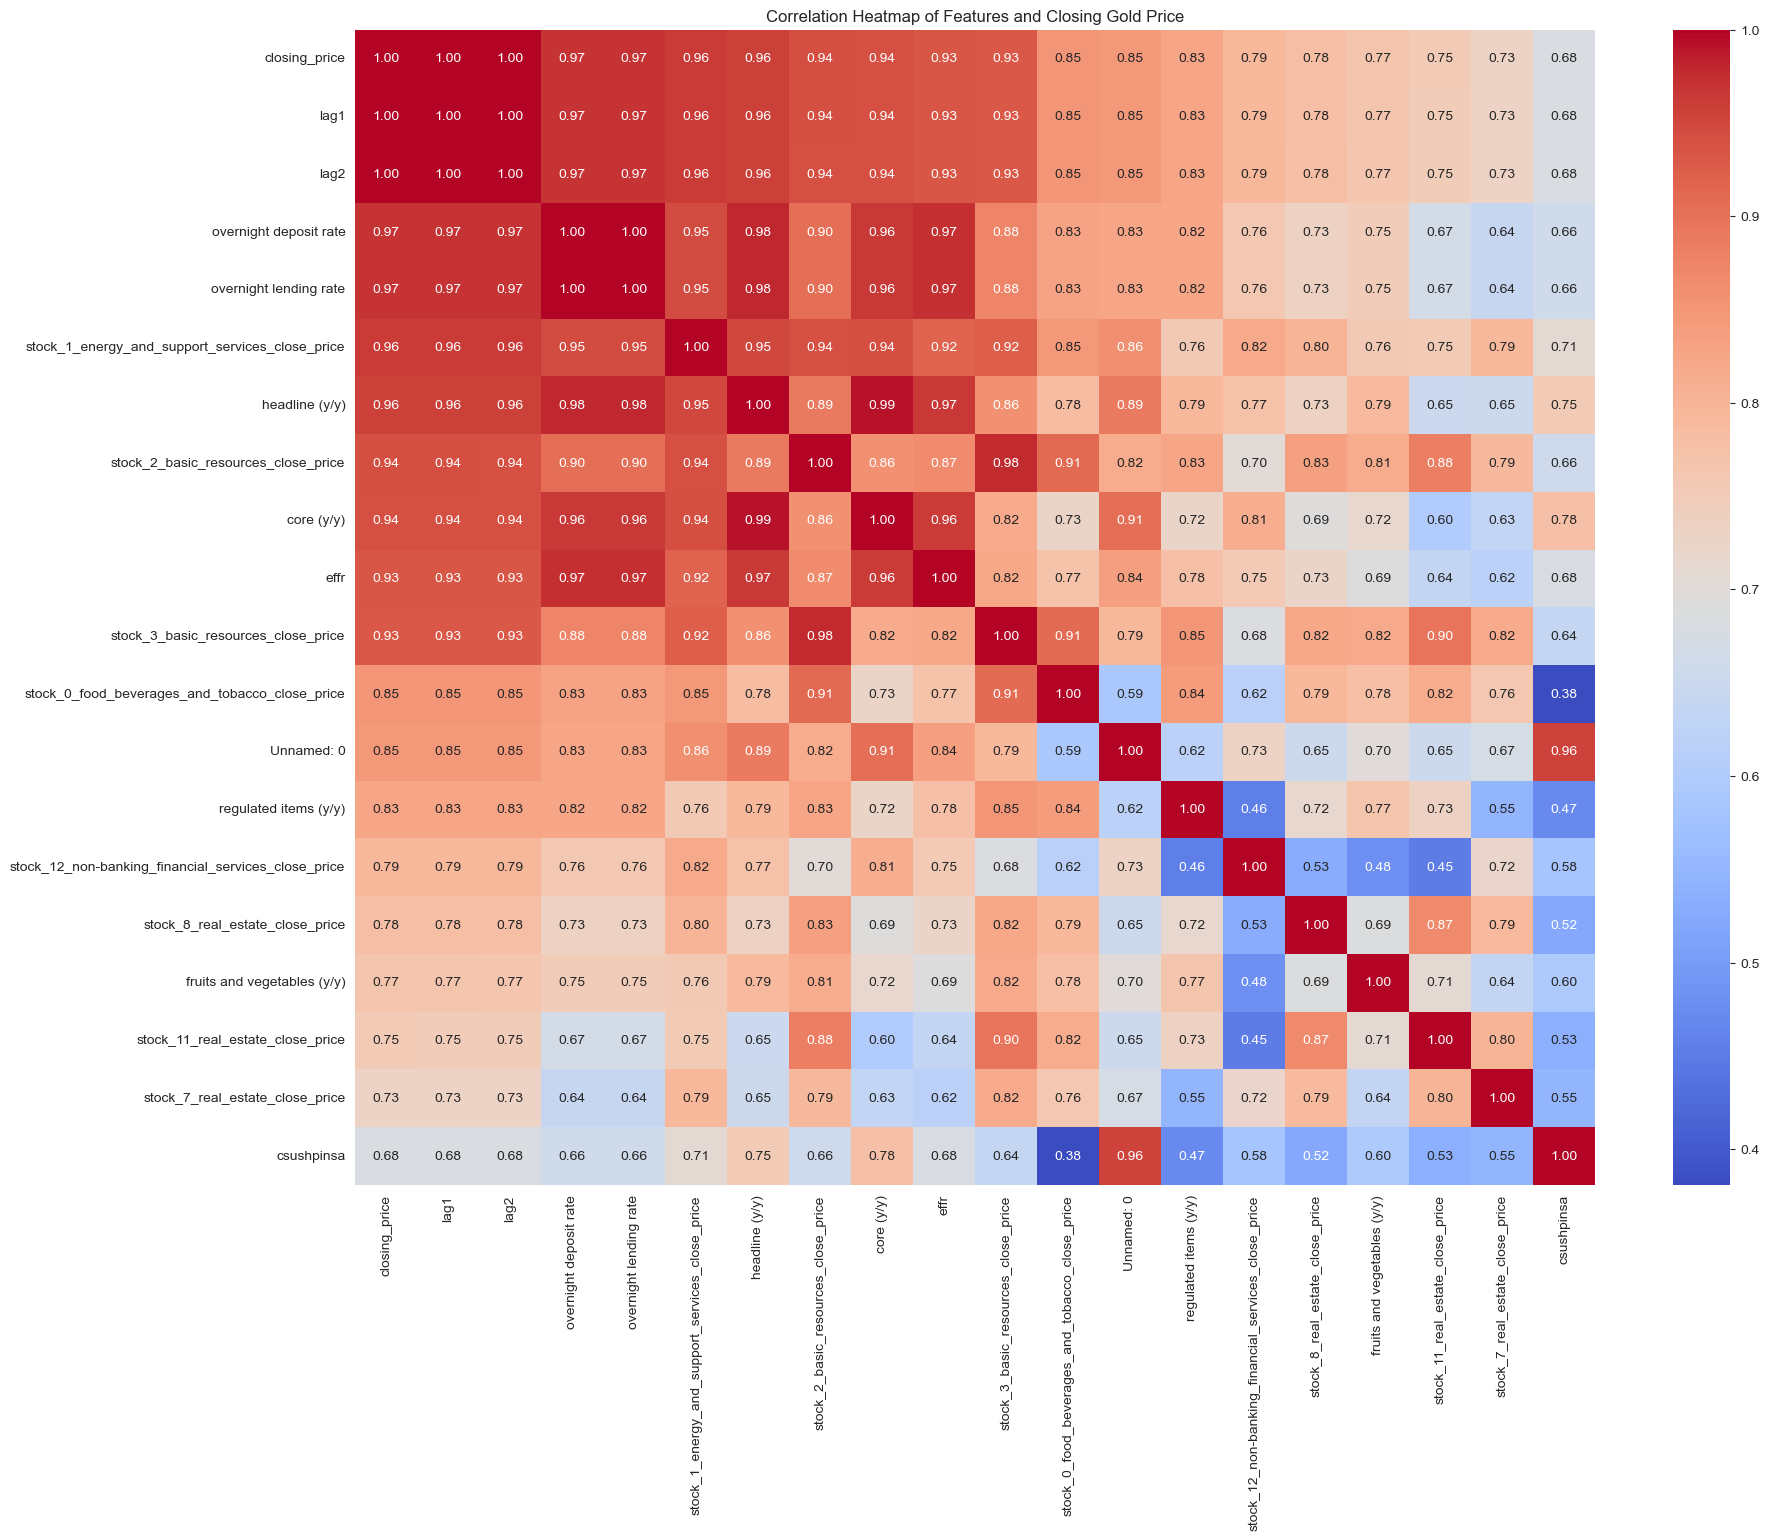

In [257]:
# `df` is the dataset with your features and gold prices
df = merged.copy()  # Make a copy to work with
# drop non_numeric columns
df = df.select_dtypes(include=['int64', 'float64'])
# Step 2: Correlation Heatmap
plt.figure(figsize=(20,15))
correlation_matrix = df.corr()
top_feat = correlation_matrix.nlargest(num_feat_to_include,'closing_price').index
# Visualizing the correlation matrix
sns.heatmap(correlation_matrix.loc[top_feat,top_feat], annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Features and Closing Gold Price')
plt.show()

# Visualizing features with `Closing_Gold_prices`

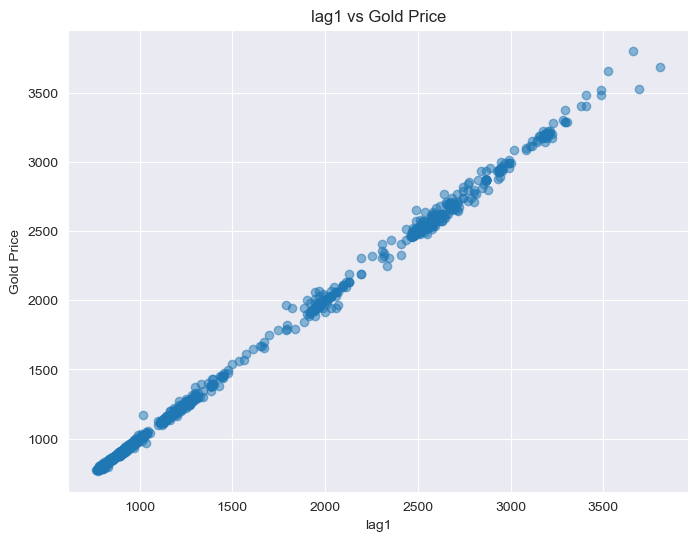

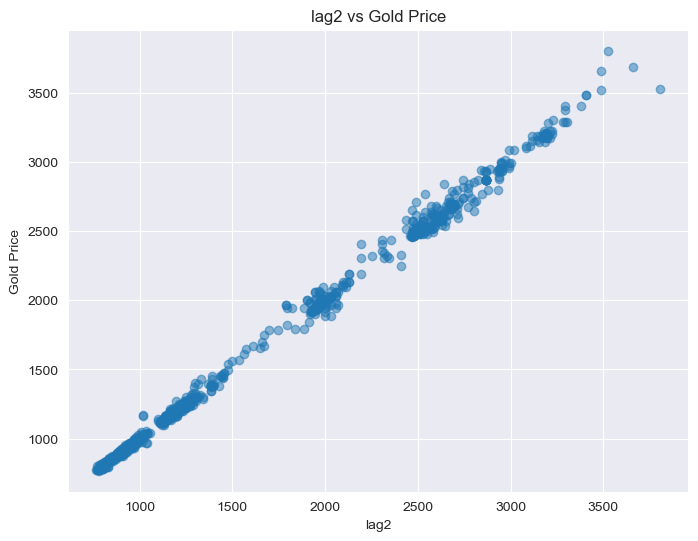

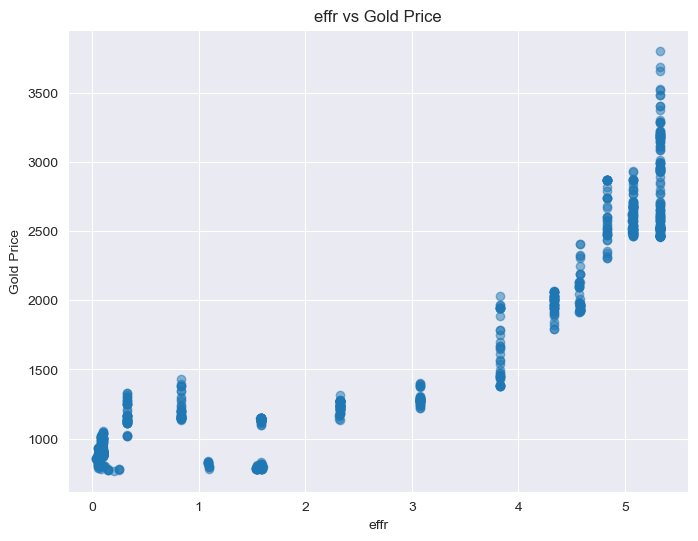

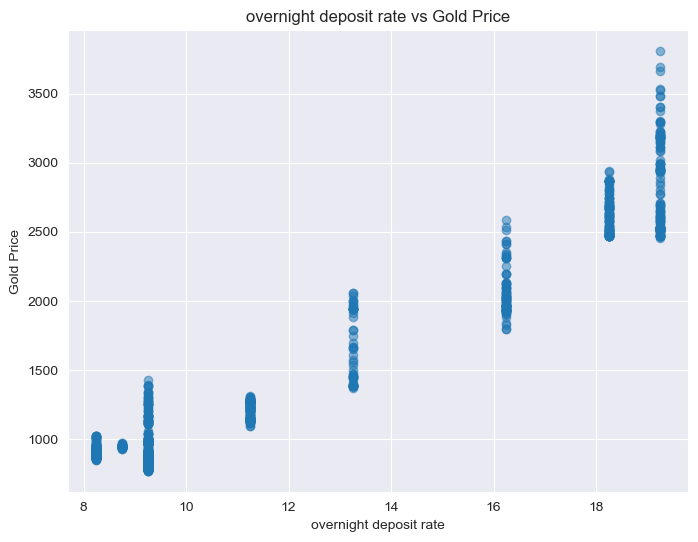

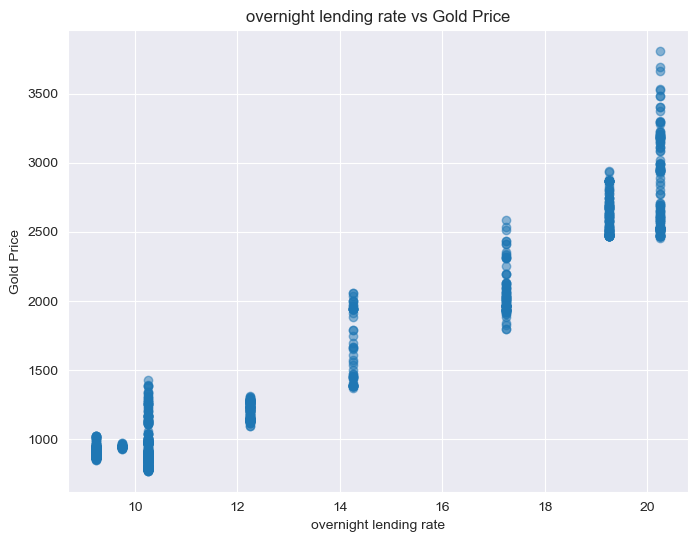

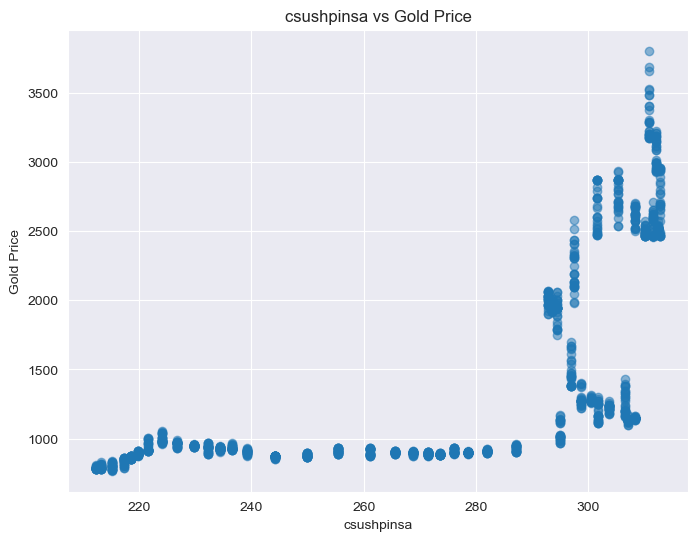

In [258]:
# Step 3: Visualizing individual feature relationships with gold price change
features = ['lag1', 'lag2','effr', 'overnight deposit rate', 'overnight lending rate', 'csushpinsa']  # Add more as needed

for feature in features:
    plt.figure(figsize=(8,6))
    plt.scatter(df[feature], df['closing_price'], alpha=0.5)
    plt.title(f'{feature} vs Gold Price')
    plt.xlabel(feature)
    plt.ylabel('Gold Price')
    plt.show()

# Model

In [259]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device_type = 'gpu' if torch.cuda.is_available() else 'cpu'

merged['time_idx'] = range(len(merged))  # Create a sequential time index
merged['group_id'] = 0  # Use a constant group ID for all data points

target = 'pct_change'
features =[]
for feat in top_feat:
    features.append(feat)

## Creating from `merged` DataFrame a Time Series Dataset

In [260]:


print(f'features list: {features}\nfeatures len: {len(features)} \ntarget: {target}')
# Create a time series dataset


# Create a TimeSeriesDataSet
training = TimeSeriesDataSet(
    merged,
    time_idx='time_idx',
    allow_missing_timesteps=False,
    target=target,
    group_ids=["group_id"],  # List of group ids; use a constant if not grouping
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=1,  # Minimum prediction length (set to 1 for next time step)
    max_prediction_length=max_prediction_length,
    static_categoricals=[],  # Include any static categorical features if available
    static_reals=[],  # Include any static real-valued features if available
    time_varying_known_categoricals=[],  # Add known categorical features if any
    time_varying_known_reals=features,  # The features that vary over time
    time_varying_unknown_categoricals=[],  # Add any unknown categorical features if available
    time_varying_unknown_reals=[],  # Add unknown real-valued features if available
    target_normalizer=None
)


features list: ['closing_price', 'lag1', 'lag2', 'overnight deposit rate', 'overnight lending rate', 'stock_1_energy_and_support_services_close_price', 'headline (y/y)', 'stock_2_basic_resources_close_price', 'core (y/y)', 'effr', 'stock_3_basic_resources_close_price', 'stock_0_food_beverages_and_tobacco_close_price', 'Unnamed: 0', 'regulated items (y/y)', 'stock_12_non-banking_financial_services_close_price', 'stock_8_real_estate_close_price', 'fruits and vegetables (y/y)', 'stock_11_real_estate_close_price', 'stock_7_real_estate_close_price', 'csushpinsa']
features len: 20 
target: pct_change


## Predicting Dataset

In [261]:

df = merged.copy()
df['dummy_target']=0
test_dataset = TimeSeriesDataSet(
    df[:900],
    time_idx='time_idx',
    allow_missing_timesteps=False,
    predict_mode=True,
    target='dummy_target',
    target_normalizer=None,
    group_ids=["group_id"],  # List of group ids; use a constant if not grouping
    min_encoder_length=60,
    max_encoder_length=100,
    min_prediction_length=600,  # Minimum prediction length (set to 1 for next time step)
    max_prediction_length=700,
    static_categoricals=[],  # Include any static categorical features if available
    static_reals=[],  # Include any static real-valued features if available
    time_varying_known_categoricals=[],  # Add known categorical features if any
    time_varying_known_reals=features,  # The features that vary over time
    time_varying_unknown_categoricals=[],  # Add any unknown categorical features if available
    time_varying_unknown_reals=[]  # Add unknown real-valued features if available
)
# print((test_dataset.data))
test_dl = DataLoader(test_dataset, batch_size=1, collate_fn=test_dataset._collate_fn)
test_dl.batch_size


1

## Splitting the Dataset to val and train

In [262]:

# Manually split the dataset using indices
train_size = int(ratio_of_data_splitting * len(training))
print(train_size)
# Create training and validation datasets using slicing
train_dataset = training.get_parameters()
val_dataset = training.get_parameters()
print(val_dataset)
print(train_dataset)
train_dataset = TimeSeriesDataSet(
    merged.iloc[:train_size],  # Training data
    **train_dataset  # Keep other parameters the same as original dataset
)
val_dataset = TimeSeriesDataSet(
    merged.iloc[train_size:],  # Validation data
    **val_dataset
    
)
# Create DataLoaders

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, collate_fn=train_dataset._collate_fn, num_workers=num_workers, persistent_workers=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True, collate_fn=val_dataset._collate_fn, num_workers=num_workers, persistent_workers=True)
print(len(val_dataset))

1087
{'time_idx': 'time_idx', 'target': 'pct_change', 'group_ids': ['group_id'], 'weight': None, 'max_encoder_length': 100, 'min_encoder_length': 100, 'min_prediction_idx': 0, 'min_prediction_length': 1, 'max_prediction_length': 200, 'static_categoricals': [], 'static_reals': [], 'time_varying_known_categoricals': [], 'time_varying_known_reals': ['closing_price', 'lag1', 'lag2', 'overnight deposit rate', 'overnight lending rate', 'stock_1_energy_and_support_services_close_price', 'headline (y/y)', 'stock_2_basic_resources_close_price', 'core (y/y)', 'effr', 'stock_3_basic_resources_close_price', 'stock_0_food_beverages_and_tobacco_close_price', 'Unnamed: 0', 'regulated items (y/y)', 'stock_12_non-banking_financial_services_close_price', 'stock_8_real_estate_close_price', 'fruits and vegetables (y/y)', 'stock_11_real_estate_close_price', 'stock_7_real_estate_close_price', 'csushpinsa'], 'time_varying_unknown_categoricals': [], 'time_varying_unknown_reals': [], 'variable_groups': {}, 'co

## Wrapping the model in `pytorch_lightning.LightningModule`

In [263]:

class CustomMultiHorizonMetric(MultiHorizonMetric):

    def loss(self, y_pred , target) -> torch.Tensor:
        
        return MAE()(y_pred, target)
 

In [264]:
class TemporalFusionTransformerModule(pl.LightningModule):
    def __init__(self, model: TemporalFusionTransformer):
        super(TemporalFusionTransformerModule, self).__init__()
        self.model = model
        self.multi_horizon_metric = CustomMultiHorizonMetric()  # Initialize MultiHorizonMetric here


    def compute_loss(self, y_hat, y):
        
        # y_hat shape: (batch_size, num_horizons, features_learned)
        # y shape: (batch_size, num_horizons)

        # Initialize a list to store losses for each feature
        losses = []
        # Iterate over each learned feature
        for feature_idx in range(y_hat.shape[2]):
            feature_pred = y_hat[:, :, feature_idx]  # Shape: (batch_size, num_horizons)
            feature_loss = self.multi_horizon_metric(feature_pred, y)  # Calculate loss for this feature
            losses.append(feature_loss)

        # Combine losses (e.g., sum or average)
        total_loss = torch.mean(torch.stack(losses))  # Or use torch.sum(losses)


        return total_loss

    def forward(self, x):

        out=self.model(x)
       
        return out[0] # Ensure you're calling the model directly

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = self.compute_loss(y_hat, y[0])
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        val_loss = self.compute_loss(y_hat, y[0])
        self.log('val_loss', val_loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)  # Use model parameters
        return optimizer
    
    def predict_step(self, batch, batch_idx):
        # Check if batch is a tuple and extract the data part
        if isinstance(batch, tuple):
            x = batch[0]  # Extract data (dictionary)
        else:
            x = batch  # If it's already a dictionary

        return self(x)  # Call the forward method with only data


## Using `Trainer` from `pytorch_lightning`

## Initializing the Model `TemporalFusionTrasnformer` (TTF)

In [265]:
# Initialize the Temporal Fusion Transformer

model = TemporalFusionTransformer.from_dataset(
    train_dataset,
    reduce_on_plateau_patience=20,
    learning_rate= lr,
    hidden_size=hidden_size,
    attention_head_size=attention_head_size,
    dropout=DropOut,
    hidden_continuous_size=hidden_continuous_size,
    loss = CustomMultiHorizonMetric()
).to(device)

# Define a trainer
module = TemporalFusionTransformerModule(model).to(device)



C:\Users\Mazen\anaconda3\envs\beltone-hackathon\lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
C:\Users\Mazen\anaconda3\envs\beltone-hackathon\lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
C:\Users\Mazen\anaconda3\envs\beltone-hackathon\lib\site-packages\pytorch_forecasting\models\temporal_fusion_transformer\__init__.py:143: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless 

In [266]:
trainer = Trainer(max_epochs=100, accelerator=device_type, devices=1)
# Fit the model
module.train()
trainer.fit(
    module,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                 | Type                      | Params | Mode 
---------------------------------------------------------------------------
0 | model                | TemporalFusionTransformer | 141 K  | train
1 | multi_horizon_metric | CustomMultiHorizonMetric  | 0      | train
---------------------------------------------------------------------------
141 K     Trainable params
0         Non-trainable params
141 K     Total params
0.567     Total estimated model params size (MB)
737       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [267]:
# Optionally, evaluate the model
module.eval()
metrics = trainer.validate(module, dataloaders=val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        val_loss           0.0020799448247998953
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Predicting with the model


In [268]:
# Get predictions
predictions = trainer.predict(module, dataloaders=test_dl)
predictions = predictions[0].mean(dim=2)
((predictions[0].shape))

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Mazen\anaconda3\envs\beltone-hackathon\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

torch.Size([700])

In [269]:
# ys=[]
# for x,y in iter(val_dataloader):
#     # print(y[0].shape)
#     ys.append(y[0])
# yss=torch.cat(ys,dim=1)

# yss.shape
# predictions[0]
predictions[0][0]

tensor(-0.2894)

actual tensor(0.)
predictrd torch.Size([700])


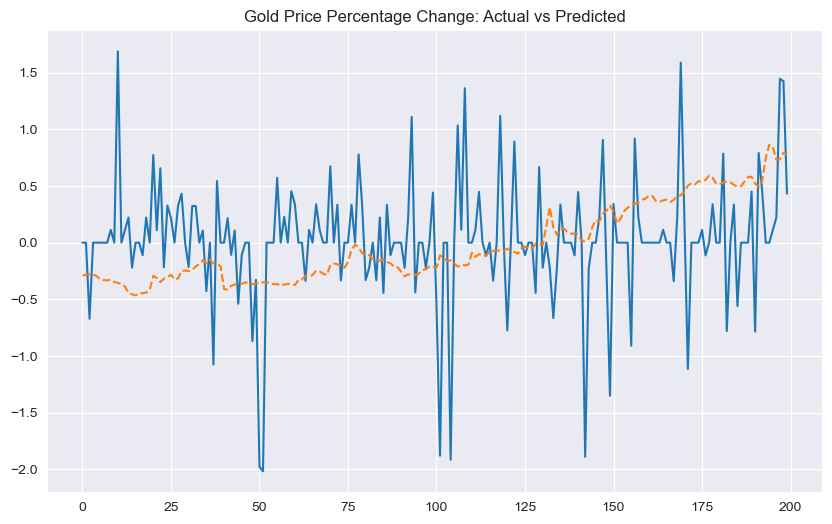

In [270]:
# Test predictions
actuals = torch.cat([y[0] for x, y in iter(train_dataloader)],dim=1)

print('actual',actuals[0][0])
print('predictrd',predictions[0].shape)
# Visualize the results
plt.figure(figsize=(10, 6))
plt.plot(actuals[0][:max_prediction_length], label='Actual')
plt.plot(predictions[0][:max_prediction_length], label='Predicted', linestyle='--')
plt.title('Gold Price Percentage Change: Actual vs Predicted')
plt.show()


In [276]:
val_loss = metrics[0]['val_loss']
val_loss

0.0020799448247998953

In [277]:
import os
# Save the trained model state dictionary
os.mkdir('../Checkpoints')
torch.save(module.state_dict(), os.path.join('../Checkpoints', f'tft_model_{val_loss}.pth'))

In [279]:
# Recreate the model architecture
model = TemporalFusionTransformer.from_dataset(
    train_dataset,
    reduce_on_plateau_patience=20,
    learning_rate=lr,
    hidden_size=hidden_size,
    attention_head_size=attention_head_size,
    dropout=DropOut,
    hidden_continuous_size=hidden_continuous_size,
    loss=CustomMultiHorizonMetric()
).to(device)

# Initialize the Lightning module
loaded_module = TemporalFusionTransformerModule(model).to(device)

# Load the state dictionary
loaded_module.load_state_dict(torch.load(os.path.join('../Checkpoints', f'tft_model_{val_loss}.pth')))


C:\Users\Mazen\anaconda3\envs\beltone-hackathon\lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
C:\Users\Mazen\anaconda3\envs\beltone-hackathon\lib\site-packages\lightning\pytorch\utilities\parsing.py:208: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
C:\Users\Mazen\anaconda3\envs\beltone-hackathon\lib\site-packages\pytorch_forecasting\models\temporal_fusion_transformer\__init__.py:143: UserWarning: In pytorch-forecasting models, on versions 1.1.X, the default optimizer defaults to 'adam', if pytorch_optimizer is not installed, otherwise it defaults to 'ranger' from pytorch_optimizer. From version 1.2.0, the default optimizer will be 'adam' regardless 

<All keys matched successfully>

In [280]:
# Set to evaluation mode for inference
loaded_module.eval()

# Make predictions using the loaded model
predictions = trainer.predict(loaded_module, dataloaders=test_dl)
predictions = predictions[0].mean(dim=2)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\Mazen\anaconda3\envs\beltone-hackathon\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]